In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)

full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')
full_data.head()

,CALL_TYPE_FINAL,CALL_TYPE_FINAL_D,YCOORD,XCOORD,DATE_TIME
0,773A,UNCONSCIOUS PERS,39.824332,-86.236119,2006-12-28 04:45:48
1,774A,ASSAULT/TRAUMA,39.781627,-86.120826,2006-12-28 04:48:53
2,768A,SEIZURE,39.756840,-85.998714,2006-12-28 04:52:19
3,773A,UNCONSCIOUS PERS,39.782064,-86.044592,2006-12-28 05:10:57
4,790A,*MEDICAL ALARM,39.742415,-86.111559,2006-12-28 05:17:56


In [18]:
start = 300000
end = start + 2000
data = full_data[start:end]
data.reset_index(drop=True, inplace=True)

all_events = PointProcessTrain(data, xgridsize = 75, ygridsize = 75, w = [.07,.007, .005], time_scale_label = 'hours')

In [19]:
all_events.train()

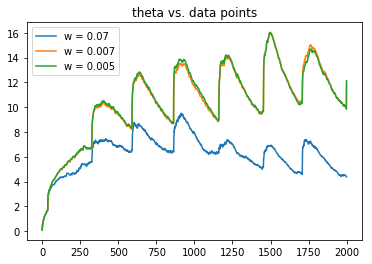


Hour vector: 
[0.02269107 0.01287048 0.01715526 0.01183926 0.01098546 0.00766475
 0.01087327 0.02538499 0.01803279 0.01734975 0.02882428 0.04824648
 0.03631042 0.04097157 0.02974109 0.05250755 0.0550569  0.07293048
 0.0599337  0.07860934 0.07584964 0.07517506 0.085281   0.1057154 ]
Day vector: 
[4.94328043e-26 2.04223038e-19 6.87208241e-13 3.29282183e-07
 9.49999671e-01 5.00000000e-02 4.09788042e-32]


In [20]:
all_events.param_examine()

In [28]:
test_points = full_data[end:end+3]
test_points.reset_index(drop=True, inplace=True)
all_events.principal_intensity_examine(test_points)

Predicting over time of 0.0544445664 hours. Generating 1 intensity predictions


AxisError: axis 2 is out of bounds for array of dimension 2

In [22]:
all_events.model_hotspot_examine(300)

93.71998828313016 (27, 41) 1.2374093555630836 (0, 0)
6.0 (27, 41)
Time period is 24.8942224296 hours

Top model hotspots in real top 10:
Grid: (27, 41), Model: 7.776954114732494, Real: 6
Grid: (27, 31), Model: 6.6744623970441666, Real: 5
Grid: (26, 31), Model: 6.171218767874183, Real: 4
Grid: (26, 32), Model: 3.50029617653962, Real: 4
Grid: (26, 41), Model: 3.145892647345967, Real: 4
Grid: (25, 31), Model: 2.8652773737225696, Real: 4
Grid: (26, 27), Model: 2.6260013938235836, Real: 4
Grid: (30, 32), Model: 2.561734982691541, Real: 6

Top model hotstpots not in real top 10
Grid: (26, 34), Model: 3.102912129193973, Real: 3
Grid: (26, 28), Model: 2.896846527184129, Real: 1

Real top 10 hotspots not predicted by model
Grid: (34, 44), Model: 1.5765887428485437, Real: 5
Grid: (27, 29), Model: 2.001640245601243, Real: 4


In [25]:
Event_Type_Lookup = {}
for i in range(0, len(full_data)):
    key = full_data.CALL_TYPE_FINAL[i]
    val = full_data.CALL_TYPE_FINAL_D[i]
    Event_Type_Lookup.setdefault(key, [])
    if val not in Event_Type_Lookup[key]:
        Event_Type_Lookup[key].append(val)